In [61]:
import numpy
import pandas
import geopandas
import pysal
import seaborn
import contextily
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from shapely.geometry import Point


import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.patches import Polygon, Circle, Rectangle, Patch
from matplotlib.lines import Line2D

In [62]:
df_crime_la = pandas.read_csv("./Crime_Data_LA_2024.csv")

In [63]:
df_crime_la.head()

DR_NO        Date Rptd         DATE OCC  TIME OCC  AREA  AREA NAME  \
0  251404027  12/30/2024 0:00  12/30/2024 0:00      2300    14    Pacific   
1  251404034  12/31/2024 0:00  12/30/2024 0:00      2230    14    Pacific   
2  240218331  12/30/2024 0:00  12/30/2024 0:00       645     2    Rampart   
3  251404035  12/30/2024 0:00  12/30/2024 0:00      1720    14    Pacific   
4  240317263  12/31/2024 0:00  12/30/2024 0:00      1830     3  Southwest   

   Rpt Dist No  Part 1-2  Crm Cd  \
0         1494         1     761   
1         1494         1     341   
2          236         1     330   
3         1494         1     341   
4          327         1     510   

                                         Crm Cd Desc  ... Status  Status Desc  \
0                                    BRANDISH WEAPON  ...     IC  Invest Cont   
1  THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...  ...     IC  Invest Cont   
2                              BURGLARY FROM VEHICLE  ...     IC  Invest Cont   
3  THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...  ...     IC  Invest Cont   
4                                   VEHICLE - STOLEN  ...     IC  Invest Cont   

  Crm Cd 1 Crm Cd 2  Crm Cd 3 Crm Cd 4  \
0      761      NaN       NaN      NaN   
1      341      NaN       NaN      NaN   
2      330      NaN       NaN      NaN   
3      341      NaN       NaN      NaN   
4      510      NaN       NaN      NaN   

                                  LOCATION Cross Street      LAT       LON  
0  9600    SKY                          WY          NaN  33.9457 -118.3998  
1   800    WORLD                        WY          NaN  33.9434 -118.3987  
2                              BONNIE BRAE      BEVERLY  34.0656 -118.2663  
3   300    WORLD                        WY          NaN  33.9455 -118.4001  
4  1100 W  28TH                         ST          NaN  34.0294 -118.2840  

[5 rows x 28 columns]

In [64]:


pts = df_crime_la.apply(lambda r: Point(r.LON, r.LAT), axis=1)
gdb = geopandas.GeoDataFrame(
    df_crime_la.assign(geometry=pts),
    crs="EPSG:4326"  # Correct syntax
)
gdb = gdb.to_crs(epsg=3857)

xys = gdb['geometry'].apply(lambda pt: pandas.Series({'x': pt.x, 'y': pt.y}))
gdb['x'] = xys['x']
gdb['y'] = xys['y']

Seaborn is a Python data visualization library built on top of Matplotlib and closely integrated with Pandas. It provides high-level functions to create aesthetically pleasing and informative statistical graphics.

Website: https://seaborn.pydata.org/

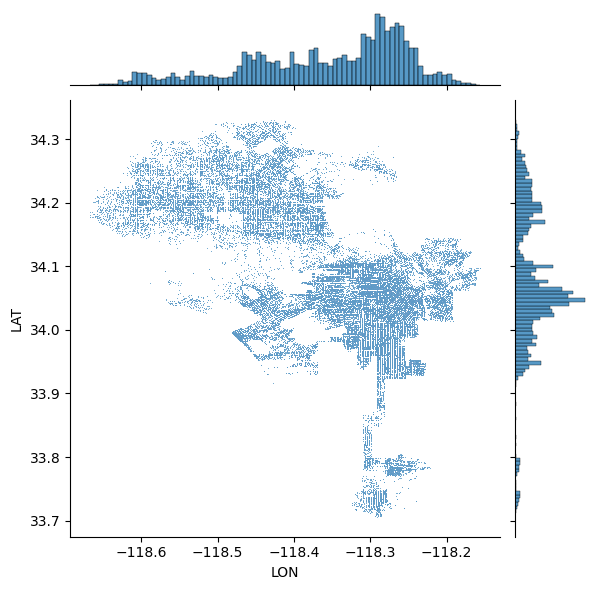

In [65]:
# Generate scatter plot
seaborn.jointplot(x="LON", y="LAT", data=gdb, s=0.5);

contextily is a Python package used to add basemaps (background maps) to geospatial data visualizations in Matplotlib and Geopandas plots. It works by fetching web tiles from online map providers (e.g., OpenStreetMap, Stamen, Carto) and overlaying them onto geospatial plots.

Official Documentation: https://contextily.readthedocs.io/

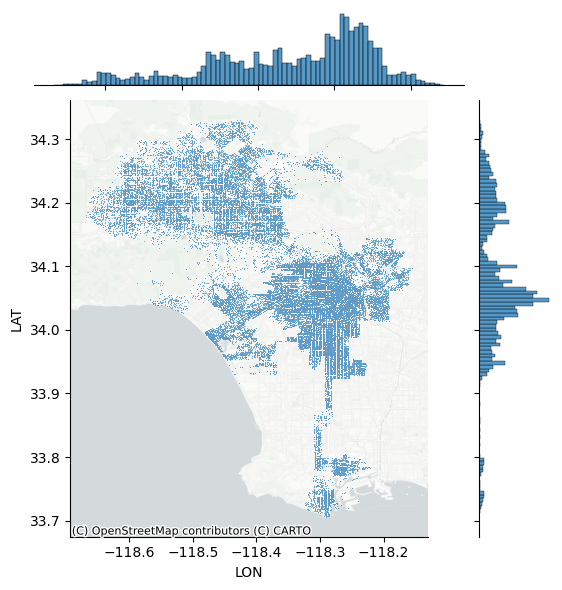

In [66]:
# Generate scatter plot
joint_axes = seaborn.jointplot(
    x="LON", y="LAT", data=gdb, s=0.5
)
contextily.add_basemap(
    joint_axes.ax_joint,
    crs="EPSG:4326",
    source=contextily.providers.CartoDB.PositronNoLabels,
);

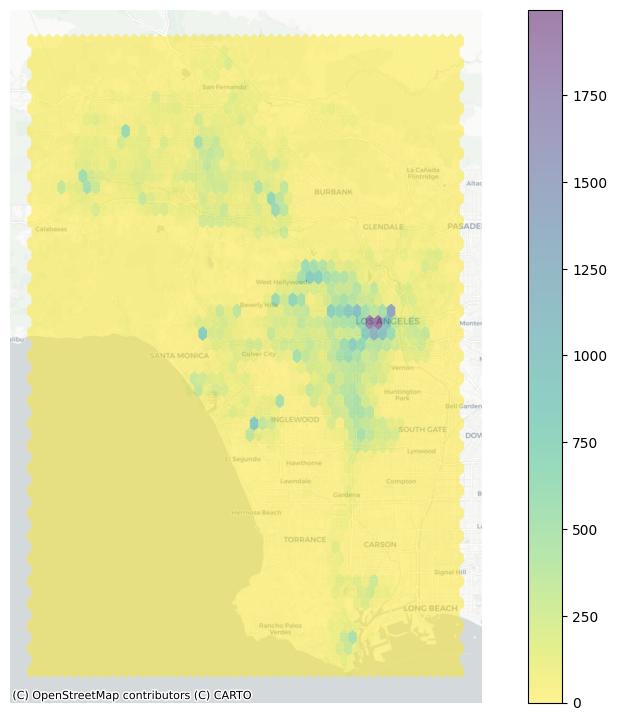

In [67]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(12, 9))
# Generate and add hexbin with 50 hexagons in each
# dimension, no borderlines, half transparency,
# and the reverse viridis colormap
hb = ax.hexbin(
    gdb["x"],
    gdb["y"],
    gridsize=50,
    linewidths=0,
    alpha=0.5,
    cmap="viridis_r",
)
# Add basemap
contextily.add_basemap(
    ax, source=contextily.providers.CartoDB.Positron
)
# Add colorbar
plt.colorbar(hb)
# Remove axes
ax.set_axis_off()

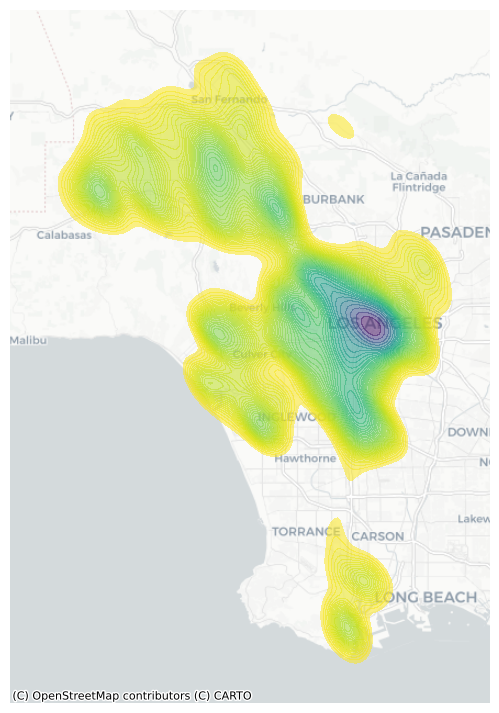

In [68]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Generate and add KDE with a shading of 50 gradients
# coloured contours, 75% of transparency,
# and the reverse viridis colormap
seaborn.kdeplot(
    x="x",
    y="y",
    data=gdb,
    n_levels=50,
    fill=True,
    alpha=0.55,
    cmap="viridis_r",
)
# Add basemap
contextily.add_basemap(
    ax, source=contextily.providers.CartoDB.Positron
)
# Remove axes
ax.set_axis_off()

In [69]:
from pointpats import centrography

In [70]:
mean_center = centrography.mean_center(gdb[["x", "y"]])
med_center = centrography.euclidean_median(gdb[["x", "y"]])

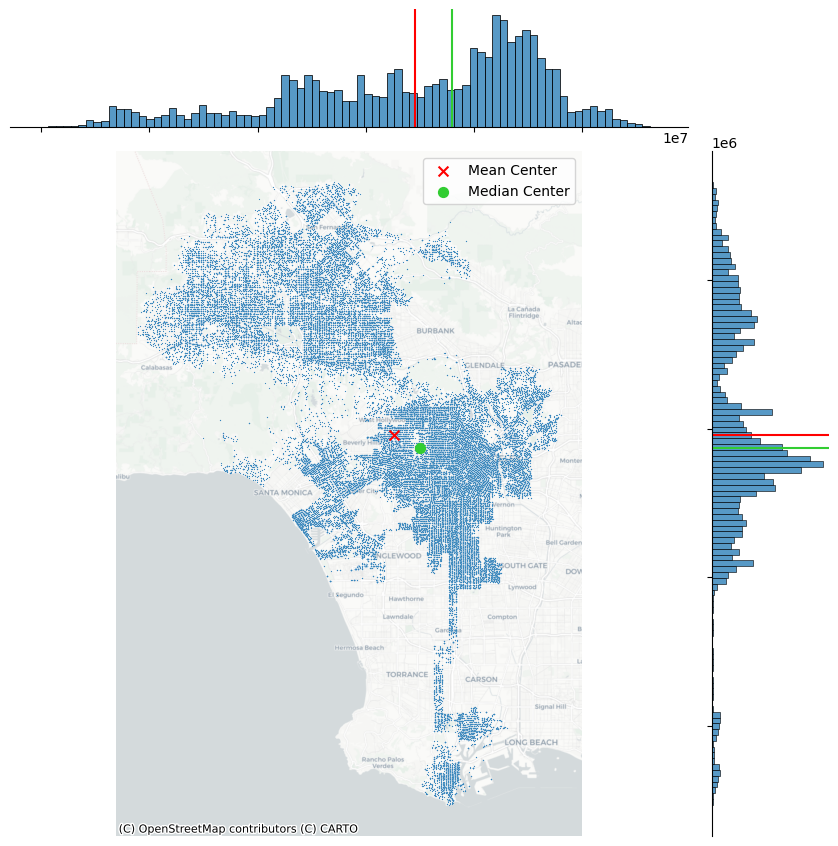

In [71]:
# Generate scatterplot
joint_axes = seaborn.jointplot(
    x="x", y="y", data=gdb, s=0.75, height=9
)
# Add mean point and marginal lines
joint_axes.ax_joint.scatter(
    *mean_center, color="red", marker="x", s=50, label="Mean Center"
)
joint_axes.ax_marg_x.axvline(mean_center[0], color="red")
joint_axes.ax_marg_y.axhline(mean_center[1], color="red")
# Add median point and marginal lines
joint_axes.ax_joint.scatter(
    *med_center,
    color="limegreen",
    marker="o",
    s=50,
    label="Median Center"
)
joint_axes.ax_marg_x.axvline(med_center[0], color="limegreen")
joint_axes.ax_marg_y.axhline(med_center[1], color="limegreen")
# Legend
joint_axes.ax_joint.legend()
# Add basemap
contextily.add_basemap(
    joint_axes.ax_joint, source=contextily.providers.CartoDB.Positron
)
# Clean axes
joint_axes.ax_joint.set_axis_off()
# Display
plt.show()

In [72]:
centrography.std_distance(gdb[["x", "y"]])

19026.90572219582

In [73]:
major, minor, rotation = centrography.ellipse(gdb[["x", "y"]])

In [74]:
major

11773.983260314046

In [75]:
minor

14521.04858577387

In [76]:
rotation

-0.5785043360749267

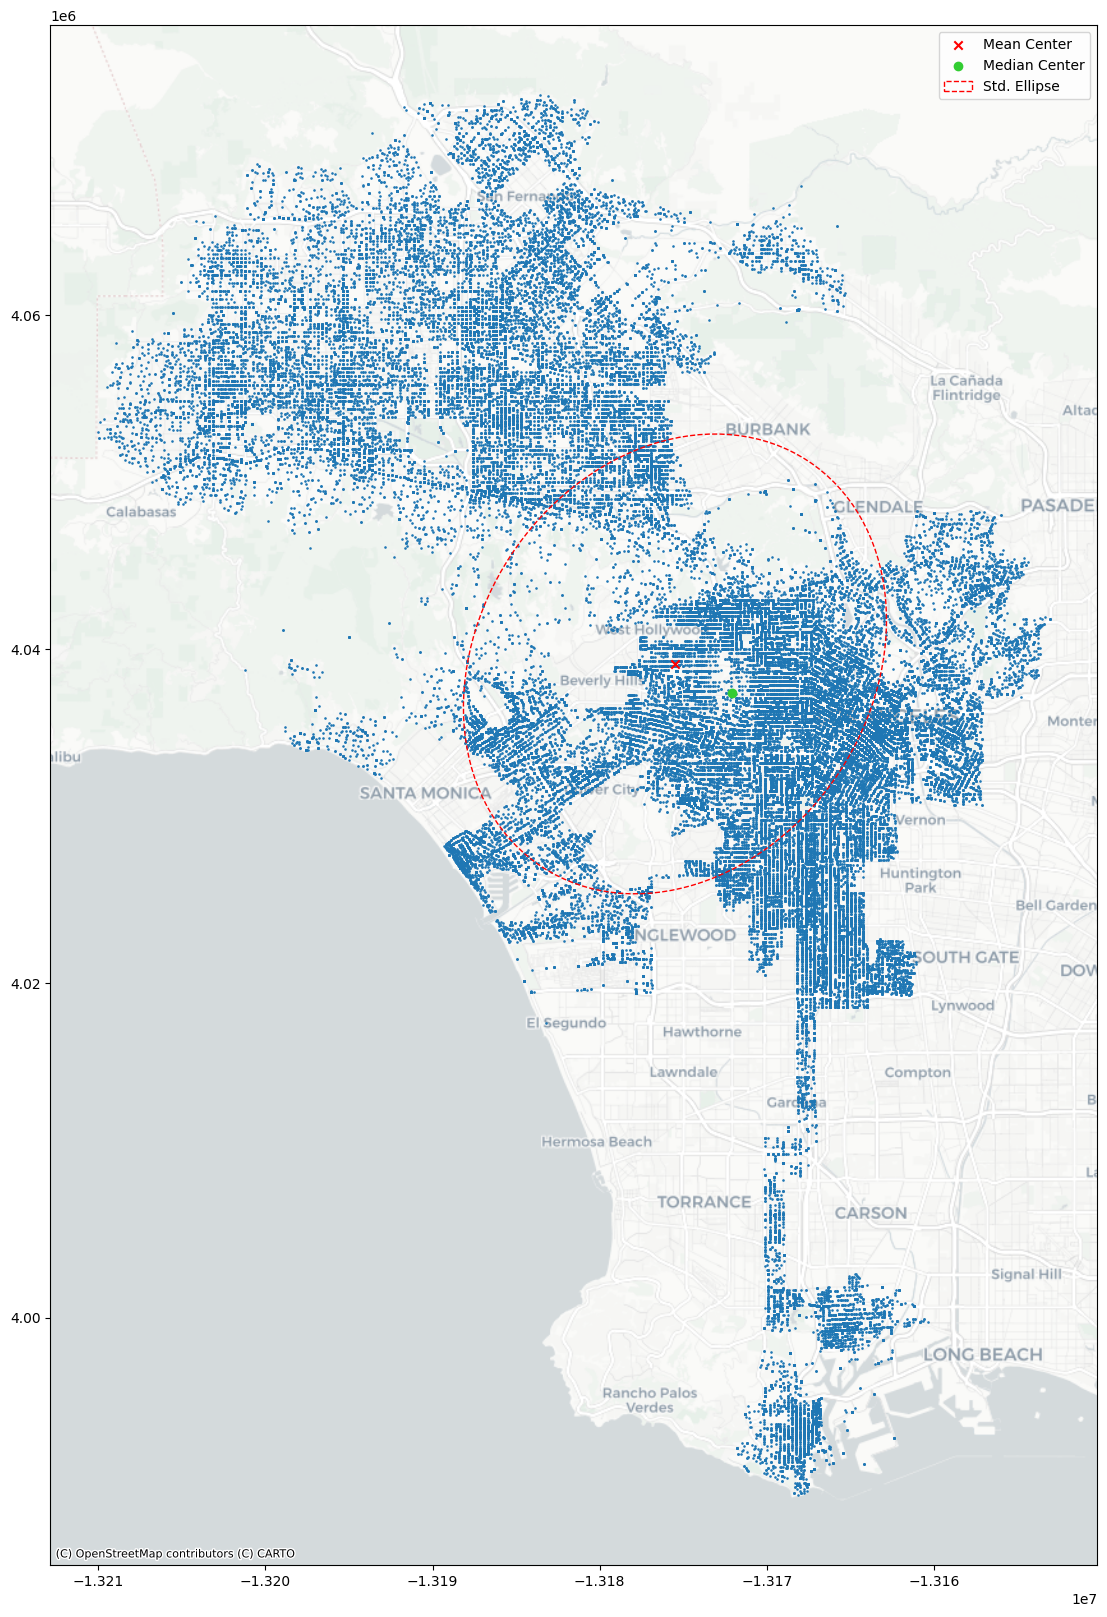

In [77]:
from matplotlib.patches import Ellipse

# Set up figure and axis
f, ax = plt.subplots(1, figsize=(20, 20))
# Plot photograph points
ax.scatter(gdb["x"], gdb["y"], s=0.75)
ax.scatter(*mean_center, color="red", marker="x", label="Mean Center")
ax.scatter(
    *med_center, color="limegreen", marker="o", label="Median Center"
)

# Construct the standard ellipse using matplotlib
ellipse = Ellipse(
    xy=mean_center,  # center the ellipse on our mean center
    width=major * 2,  # centrography.ellipse only gives half the axis
    height=minor * 2,
    angle=numpy.rad2deg(
        rotation
    ),  # Angles for this are in degrees, not radians
    facecolor="none",
    edgecolor="red",
    linestyle="--",
    label="Std. Ellipse",
)
ax.add_patch(ellipse)

ax.legend()
# Display
# Add basemap
contextily.add_basemap(
    ax, source=contextily.providers.CartoDB.Positron
)
plt.show()

In [78]:
gdb = gdb.rename(columns={"Crm Cd": "Crm_Cd"})  # Rename the column
robbery_count = gdb[gdb["Crm_Cd"] == 210]

In [79]:
robbery_count["Crm_Cd"].count()

2501

In [80]:

robbery = gdb.query("Crm_Cd == 210")  # Now query without backticks

coordinates = robbery[["x", "y"]].values

In [81]:
convex_hull_vertices = centrography.hull(coordinates)

In [82]:
import libpysal

alpha_shape, alpha, circs = libpysal.cg.alpha_shape_auto(
    coordinates, return_circles=True
)

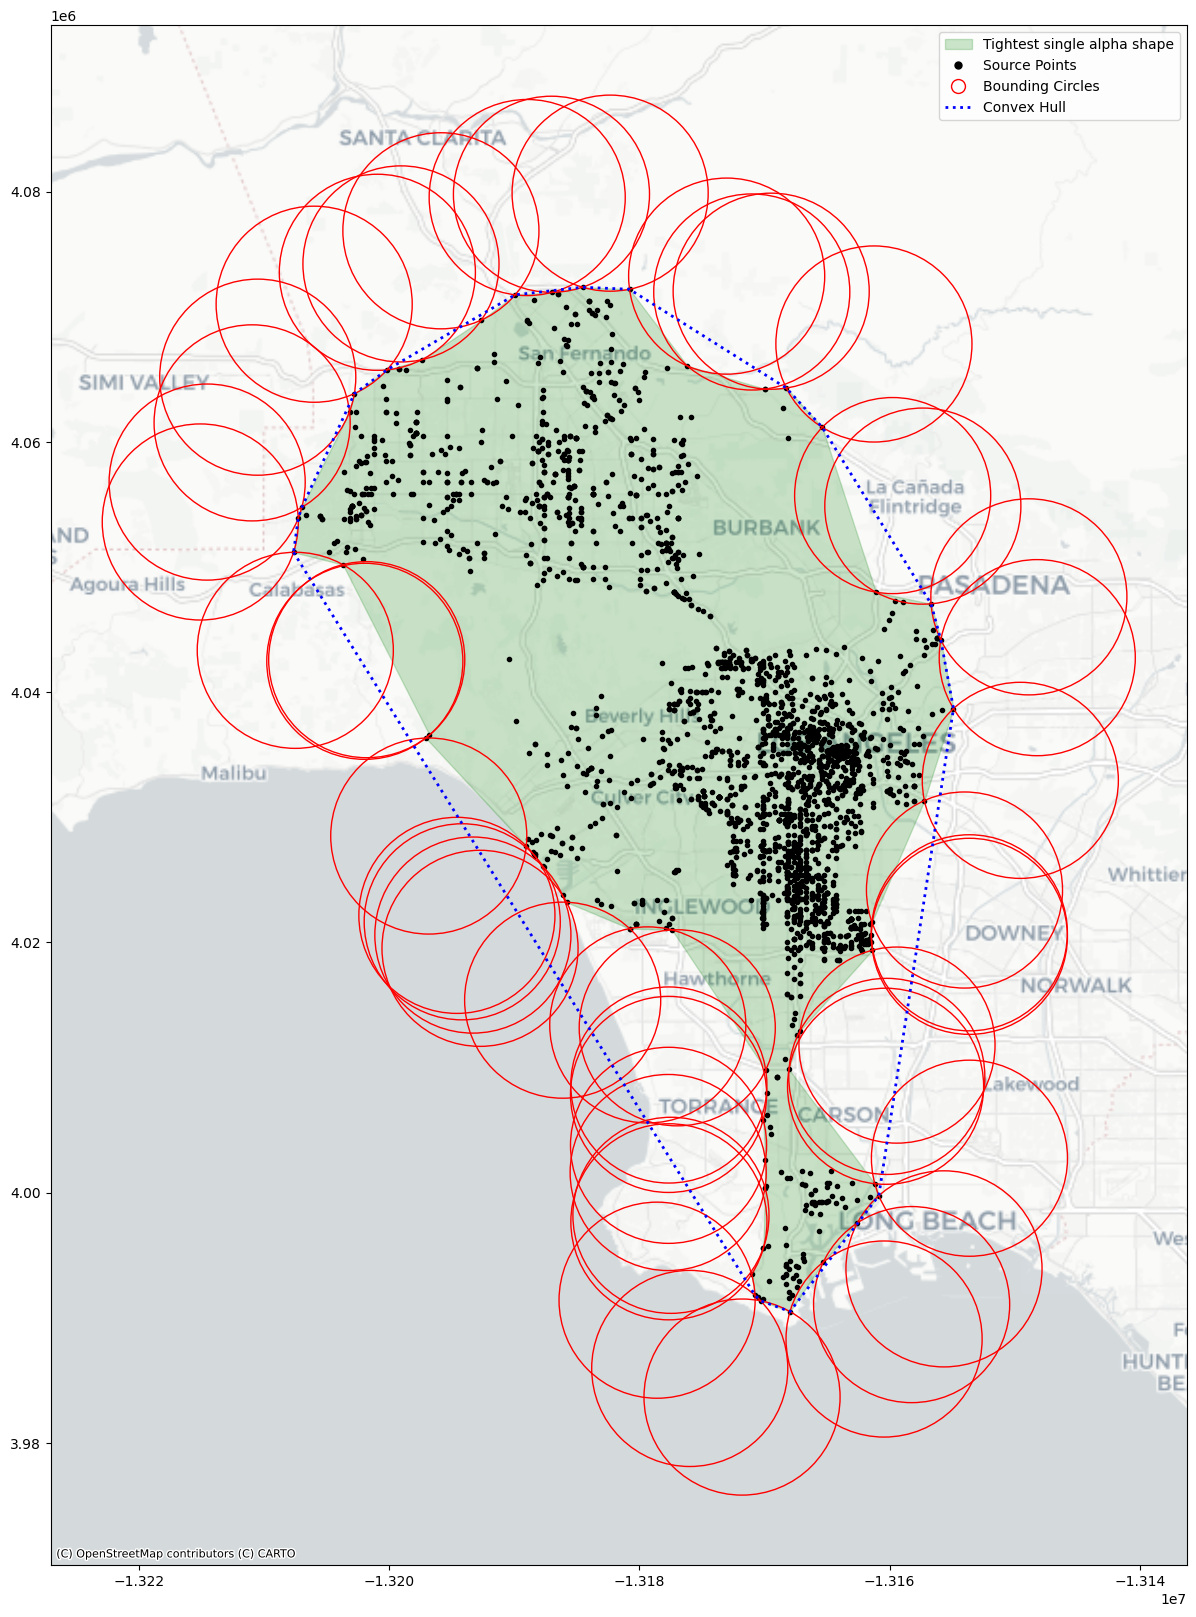

In [83]:


f, ax = plt.subplots(1, 1, figsize=(20, 20))

# Plot a green alpha shape
alpha_plot = geopandas.GeoSeries([alpha_shape]).plot(
    ax=ax, edgecolor="green", facecolor="green", alpha=0.2, label="_nolabel_"
)

# Include the points for our prolific user in black
points_plot = ax.scatter(*coordinates.T, color="k", marker=".", label="Source Points")

# Plot the circles forming the boundary of the alpha shape
circle_patches = []
for circle in circs:
    circ_patch = Circle(circle, radius=alpha, facecolor="none", edgecolor="r")
    ax.add_patch(circ_patch)
    circle_patches.append(circ_patch)

# Add a blue convex hull
convex_hull_patch = Polygon(
    convex_hull_vertices, closed=True, edgecolor="blue",
    facecolor="none", linestyle=":", linewidth=2
)
ax.add_patch(convex_hull_patch)

# Add basemap
contextily.add_basemap(ax, source=contextily.providers.CartoDB.Positron)

#  **Manually Define Legend Using the Original Symbols**
legend_elements = [
    Patch(facecolor="green", edgecolor="green", alpha=0.2, label="Tightest single alpha shape"),  # Alpha Shape
    Line2D([], [], color="black", marker=".", linestyle="None", markersize=10, label="Source Points"),  # Black Dots
    Line2D([], [], color="red", marker="o", linestyle="None", markersize=10, markerfacecolor="none", label="Bounding Circles"),  # Red Circles
    Line2D([], [], color="blue", linestyle=":", linewidth=2, label="Convex Hull"),  # Blue Convex Hull
]

ax.legend(handles=legend_elements, loc="upper right")

plt.show()


In [84]:
from pygeos import minimum_rotated_rectangle, from_shapely, to_shapely

point_array = geopandas.points_from_xy(x=robbery.x, y=robbery.y)

min_rot_rect = minimum_rotated_rectangle(
    from_shapely(
        point_array.unary_union()
    )
)
min_rot_rect = to_shapely(min_rot_rect)

In [85]:
min_rect_vertices = centrography.minimum_bounding_rectangle(
    coordinates
)

In [86]:
min_rect_vertices 

(-13207634.568556894,
 3990503.707557406,
 -13154891.393819042,
 4072363.7664709683)

In [87]:
(center_x, center_y), radius = centrography.minimum_bounding_circle(
    coordinates
)

In [88]:
from matplotlib.patches import Polygon, Circle, Rectangle

# Make a blue convex hull
convex_hull_patch = Polygon(
    convex_hull_vertices,
    closed=True,
    edgecolor="blue",
    facecolor="none",
    linestyle=":",
    linewidth=2,
    label="Convex Hull",
)

# compute the width and height of the minimum bounding rectangle
min_rect_width = min_rect_vertices[2] - min_rect_vertices[0]
min_rect_height = min_rect_vertices[3] - min_rect_vertices[1]

# Make a goldenrod minimum bounding rectangle
min_rect_patch = Rectangle(
    min_rect_vertices[0:2],
    width=min_rect_width,
    height=min_rect_height,
    edgecolor="goldenrod",
    facecolor="none",
    linestyle="dashed",
    linewidth=2,
    label="Min Bounding Rectangle",
)

# and make a red minimum bounding circle
circ_patch = Circle(
    (center_x, center_y),
    radius=radius,
    edgecolor="red",
    facecolor="none",
    linewidth=2,
    label="Min Bounding Circle",
)

In [89]:
min_rect_width 

52743.17473785207

In [90]:
min_rect_height

81860.05891356245

1️⃣ CartoDB (Light & Dark)

ctx.providers.CartoDB.Positron  # Light gray map (default)
ctx.providers.CartoDB.PositronNoLabels  # Light map (no labels)
ctx.providers.CartoDB.DarkMatter  # Dark-themed map
ctx.providers.CartoDB.DarkMatterNoLabels  # Dark map (no labels)
ctx.providers.CartoDB.Voyager  # Colorful detailed map
ctx.providers.CartoDB.VoyagerNoLabels  # Voyager map (no labels)
2️⃣ OpenStreetMap (OSM)

ctx.providers.OpenStreetMap.Mapnik  # Standard OSM map
ctx.providers.OpenStreetMap.DE  # German-style OSM map
ctx.providers.OpenStreetMap.CH  # Swiss-style OSM map
ctx.providers.OpenStreetMap.HOT  # Humanitarian OSM map
3️⃣ Esri Maps

ctx.providers.Esri.WorldStreetMap  # General Esri street map
ctx.providers.Esri.WorldImagery  # Satellite imagery
ctx.providers.Esri.WorldTopoMap  # Topographic map
ctx.providers.Esri.WorldGrayCanvas  # Gray-scale map
ctx.providers.Esri.NatGeoWorldMap  # National Geographic-style map
4️⃣ Stamen Maps

ctx.providers.Stamen.Terrain  # Terrain map with shading
ctx.providers.Stamen.TerrainBackground  # Terrain without labels
ctx.providers.Stamen.Toner  # High-contrast black & white map
ctx.providers.Stamen.TonerLite  # Lighter Toner map
ctx.providers.Stamen.Watercolor  # Artistic watercolor-styled map
5️⃣ NASA & Other Satellite Imagery

ctx.providers.NASAGIBS.ModisTerraTrueColorCR  # MODIS true-color satellite (daily)
ctx.providers.NASAGIBS.ViirsEarthAtNight2012  # Nighttime Earth lights (2012)
ctx.providers.NASAGIBS.BlueMarble  # NASA Blue Marble (natural colors)


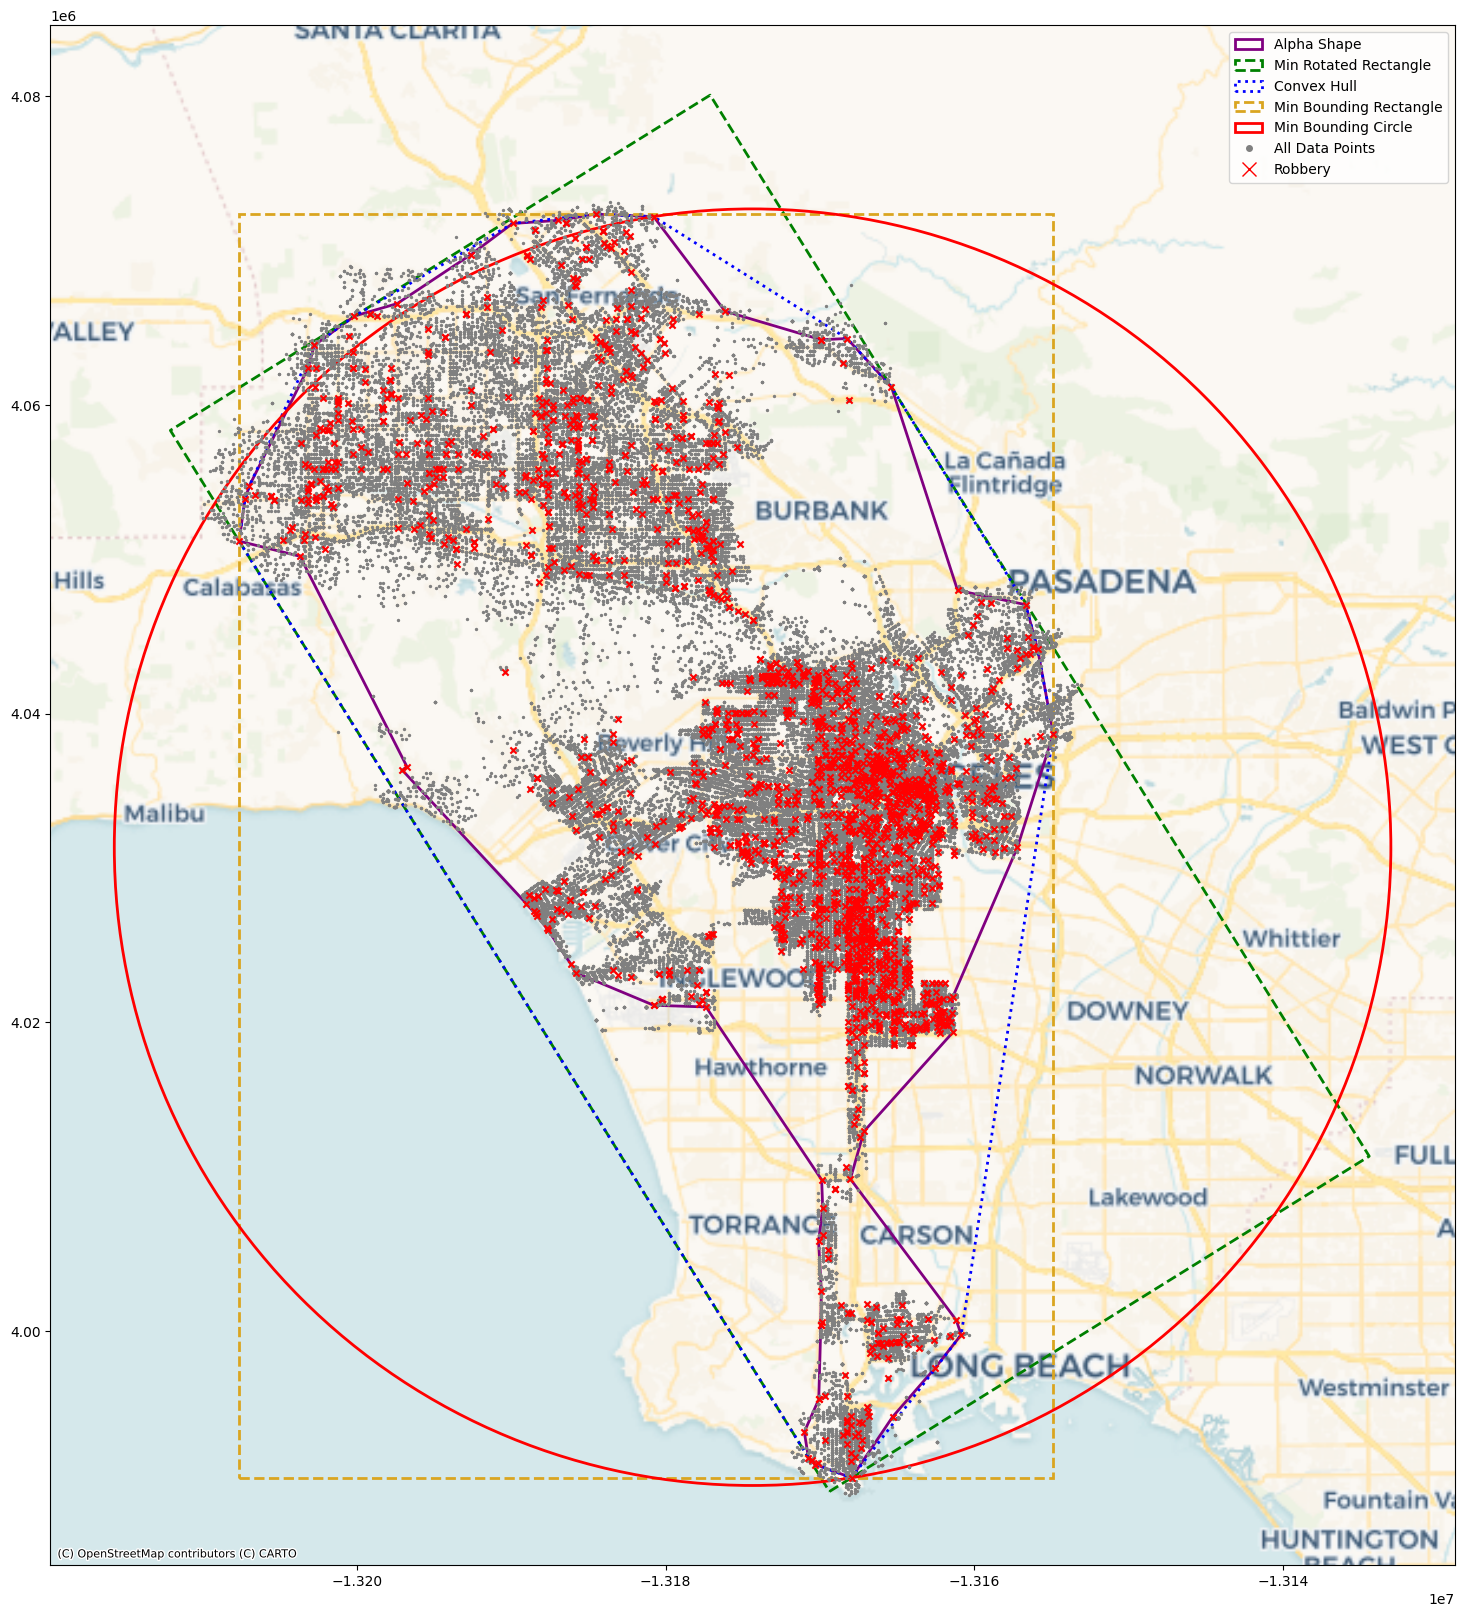

In [91]:


f, ax = plt.subplots(1, figsize=(20, 20))

# Plot Alpha Shape (purple)
geopandas.GeoSeries([alpha_shape]).plot(
    ax=ax, edgecolor="purple", facecolor="none", linewidth=2
)

# Plot Minimum Rotated Rectangle (green)
geopandas.GeoSeries([min_rot_rect]).plot(
    ax=ax, edgecolor="green", facecolor="none", linestyle="--", linewidth=2
)

# Create patch instances
convex_hull_patch_new = Polygon(
    convex_hull_vertices, closed=True, edgecolor="blue", facecolor="none", linestyle=":", linewidth=2
)

min_rect_patch_new = Rectangle(
    min_rect_vertices[0:2], width=min_rect_width, height=min_rect_height,
    edgecolor="goldenrod", facecolor="none", linestyle="dashed", linewidth=2
)

circ_patch_new = Circle(
    (center_x, center_y), radius=radius, edgecolor="red", facecolor="none", linewidth=2
)

# Add patches to plot
ax.add_patch(convex_hull_patch_new)
ax.add_patch(min_rect_patch_new)
ax.add_patch(circ_patch_new)

# Scatter plot
ax.scatter(gdb.x, gdb.y, s=2, color="grey", label="_nolegend_")  # Hide default legend
ax.scatter(robbery.x, robbery.y, s=20, color="r", marker="x", label="_nolegend_")

# Manually create legend handles with original symbols
legend_handles = [
    mpatches.Patch(edgecolor="purple", facecolor="none", linewidth=2, label="Alpha Shape"),
    mpatches.Patch(edgecolor="green", facecolor="none", linestyle="--", linewidth=2, label="Min Rotated Rectangle"),
    mpatches.Patch(edgecolor="blue", facecolor="none", linestyle=":", linewidth=2, label="Convex Hull"),
    mpatches.Patch(edgecolor="goldenrod", facecolor="none", linestyle="dashed", linewidth=2, label="Min Bounding Rectangle"),
    mpatches.Circle((0, 0), radius=5, edgecolor="red", facecolor="none", linewidth=2, label="Min Bounding Circle"),
    mlines.Line2D([], [], color="grey", marker="o", linestyle="None", markersize=4, label="All Data Points"),
    mlines.Line2D([], [], color="red", marker="x", linestyle="None", markersize=10, label="Robbery"),
]

# Add custom legend with original symbols
ax.legend(handles=legend_handles, loc="upper right")

# Add basemap
contextily.add_basemap(ax, source=contextily.providers.CartoDB.Voyager)

plt.show()


In [92]:
from pointpats import (
    distance_statistics,
    QStatistic,
    random,
    PointPattern,
)

In [104]:
random_pattern = random.poisson(coordinates, size=len(coordinates))

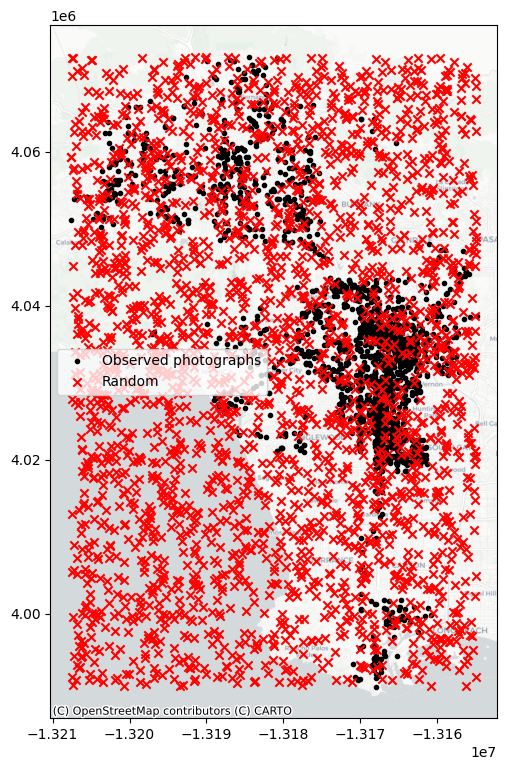

In [94]:
f, ax = plt.subplots(1, figsize=(9, 9))
plt.scatter(
    *coordinates.T,
    color="k",
    marker=".",
    label="Observed photographs"
)
plt.scatter(*random_pattern.T, color="r", marker="x", label="Random")
contextily.add_basemap(
    ax, source=contextily.providers.CartoDB.Positron
)
ax.legend(ncol=1, loc="center left")
plt.show()

In [95]:
random_pattern_ashape = random.poisson(
    alpha_shape, size=len(coordinates)
)

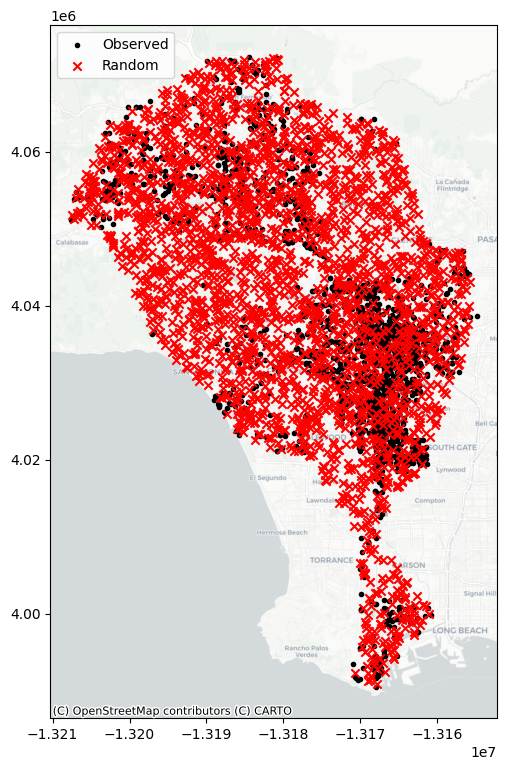

In [96]:
f, ax = plt.subplots(1, figsize=(9, 9))
plt.scatter(*coordinates.T, color="k", marker=".", label="Observed")
plt.scatter(
    *random_pattern_ashape.T, color="r", marker="x", label="Random"
)
contextily.add_basemap(
    ax, source=contextily.providers.CartoDB.Positron
)
ax.legend(ncol=1, loc="upper left")
plt.show()

<Axes: title={'center': 'Quadrat Count'}>

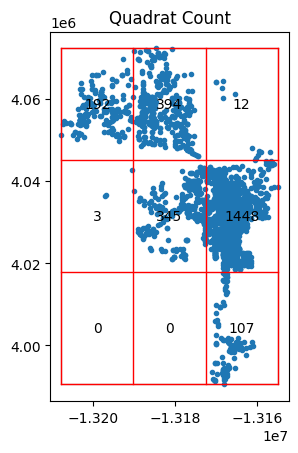

In [97]:
qstat = QStatistic(coordinates)
qstat.plot()

In [98]:
qstat.chi2_pvalue

0.0

<Axes: title={'center': 'Quadrat Count'}>

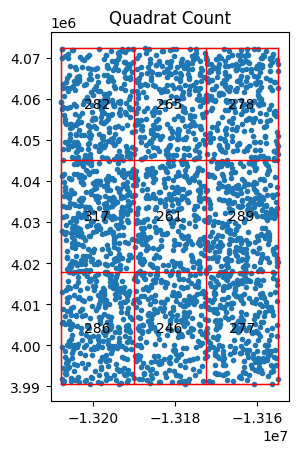

In [99]:

qstat_null = QStatistic(random_pattern)
qstat_null.plot()


In [100]:
qstat_null.chi2_pvalue

0.1732884481841772

<Axes: title={'center': 'Quadrat Count'}>

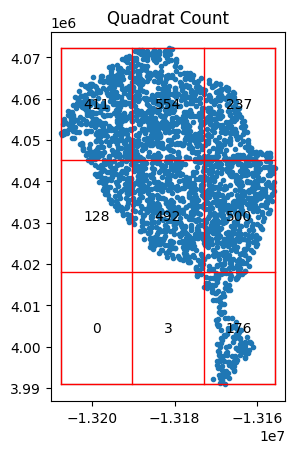

In [101]:
qstat_null_ashape = QStatistic(random_pattern_ashape)
qstat_null_ashape.plot()




In [117]:
random_pattern

array([[-13207339.63777211,   3998020.06171111],
       [-13167782.47309346,   4017416.31146291],
       [-13197937.8609809 ,   4006889.00149893],
       ...,
       [-13183083.11744322,   4031825.59421853],
       [-13173539.40671642,   4061968.87717109],
       [-13188257.25703596,   4048508.57847984]])

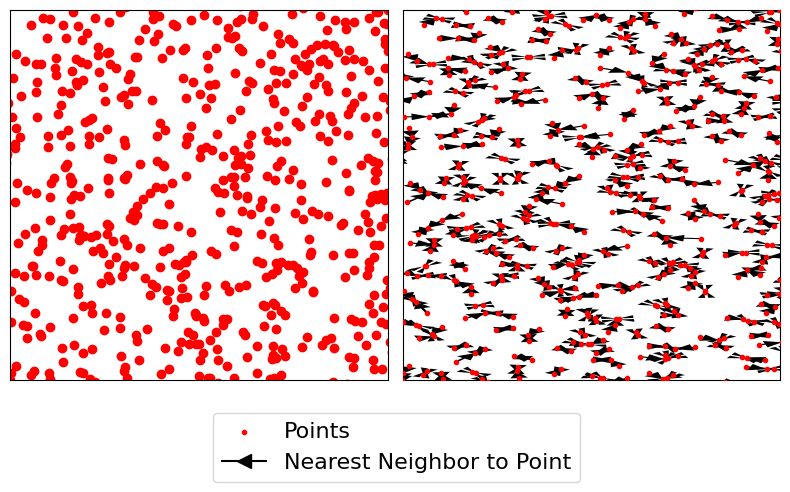

In [118]:
# Code generated for this figure is available on the web version of the book.
f, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax[0].scatter(*random_pattern.T, color="red")
ax[1].scatter(
    *random_pattern.T,
    color="red",
    zorder=100,
    marker=".",
    label="Points"
)
nn_ixs, nn_ds = PointPattern(random_pattern).knn(1)
first = True
for coord, nn_ix, nn_d in zip(random_pattern, nn_ixs, nn_ds):
    dx, dy = random_pattern[nn_ix].squeeze() - coord
    arrow = ax[1].arrow(
        *coord,
        dx,
        dy,
        length_includes_head=True,
        overhang=0,
        head_length=300 * 3,
        head_width=300 * 3,
        width=50 * 3,
        linewidth=0,
        facecolor="k",
        head_starts_at_zero=False
    )
    if first:
        plt.plot(
            (1e100, 1e101),
            (0, 1),
            color="k",
            marker="<",
            markersize=10,
            label="Nearest Neighbor to Point",
        )
    first = False

ax[0].axis([-13207339.63777211, -13188257.25703596, 3998020.06171111, 4048508.57847984])
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].set_xticks([])
ax[0].set_yticks([])
f.tight_layout()
ax[1].legend(bbox_to_anchor=(0.5, -0.06), fontsize=16)
plt.show()

In [119]:
g_test = distance_statistics.g_test(
    coordinates, support=40, keep_simulations=True
)

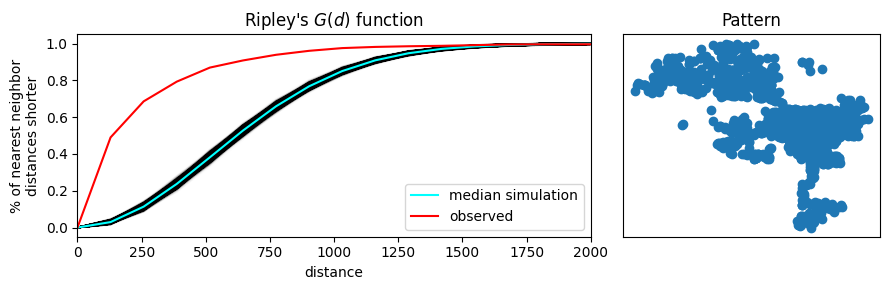

In [120]:
f, ax = plt.subplots(
    1, 2, figsize=(9, 3), gridspec_kw=dict(width_ratios=(6, 3))
)
# plot all the simulations with very fine lines
ax[0].plot(
    g_test.support, g_test.simulations.T, color="k", alpha=0.01
)
# and show the average of simulations
ax[0].plot(
    g_test.support,
    numpy.median(g_test.simulations, axis=0),
    color="cyan",
    label="median simulation",
)


# and the observed pattern's G function
ax[0].plot(
    g_test.support, g_test.statistic, label="observed", color="red"
)

# clean up labels and axes
ax[0].set_xlabel("distance")
ax[0].set_ylabel("% of nearest neighbor\ndistances shorter")
ax[0].legend()
ax[0].set_xlim(0, 2000)
ax[0].set_title(r"Ripley's $G(d)$ function")

# plot the pattern itself on the next frame
ax[1].scatter(*coordinates.T)

# and clean up labels and axes there, too
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_title("Pattern")
f.tight_layout()
plt.show()

In [121]:
f_test = distance_statistics.f_test(
    coordinates, support=40, keep_simulations=True
)

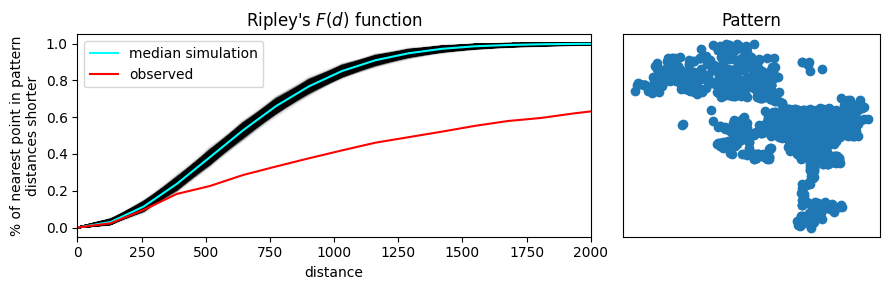

In [122]:
f, ax = plt.subplots(
    1, 2, figsize=(9, 3), gridspec_kw=dict(width_ratios=(6, 3))
)

# plot all the simulations with very fine lines
ax[0].plot(
    f_test.support, f_test.simulations.T, color="k", alpha=0.01
)
# and show the average of simulations
ax[0].plot(
    f_test.support,
    numpy.median(f_test.simulations, axis=0),
    color="cyan",
    label="median simulation",
)


# and the observed pattern's F function
ax[0].plot(
    f_test.support, f_test.statistic, label="observed", color="red"
)

# clean up labels and axes
ax[0].set_xlabel("distance")
ax[0].set_ylabel("% of nearest point in pattern\ndistances shorter")
ax[0].legend()
ax[0].set_xlim(0, 2000)
ax[0].set_title(r"Ripley's $F(d)$ function")

# plot the pattern itself on the next frame
ax[1].scatter(*coordinates.T)

# and clean up labels and axes there, too
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_title("Pattern")
f.tight_layout()
plt.show()

In [124]:
# Define DBSCAN
clusterer = DBSCAN()
# Fit to our data
clusterer.fit(gdb[["x", "y"]])

DBSCAN()

In [125]:
# Print the first 5 elements of `cs`
clusterer.core_sample_indices_[:5]

array([0, 3, 4, 5, 7], dtype=int64)

In [126]:
clusterer.labels_[:5]

array([ 0, -1, -1,  1,  2], dtype=int64)

In [128]:
lbls = pandas.Series(clusterer.labels_, index=gdb.index)

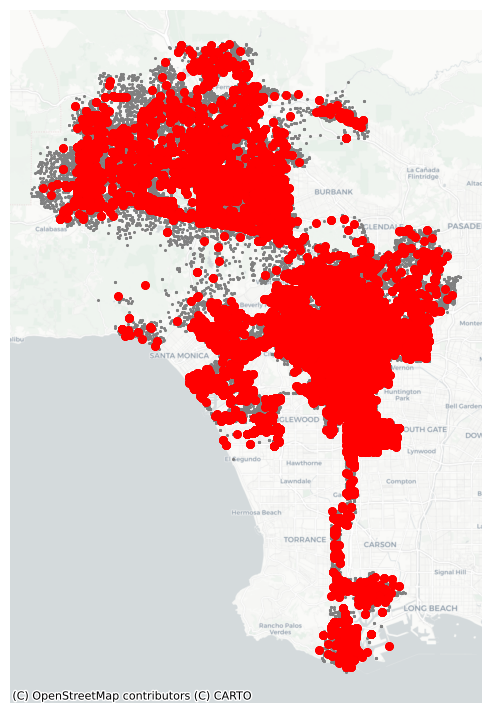

In [129]:
# Setup figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Subset points that are not part of any cluster (noise)
noise = gdb.loc[lbls == -1, ["x", "y"]]
# Plot noise in grey
ax.scatter(noise["x"], noise["y"], c="grey", s=5, linewidth=0)
# Plot all points that are not noise in red
# NOTE how this is done through some fancy indexing, where
#      we take the index of all points (tw) and substract from
#      it the index of those that are noise
ax.scatter(
    gdb.loc[gdb.index.difference(noise.index), "x"],
    gdb.loc[gdb.index.difference(noise.index), "y"],
    c="red",
    linewidth=0,
)
# Add basemap
contextily.add_basemap(
    ax, source=contextily.providers.CartoDB.Positron
)
# Remove axes
ax.set_axis_off()
# Display the figure
plt.show()

In [131]:
# Obtain the number of points 1% of the total represents
minp = numpy.round(gdb.shape[0] * 0.01)
minp

1275.0

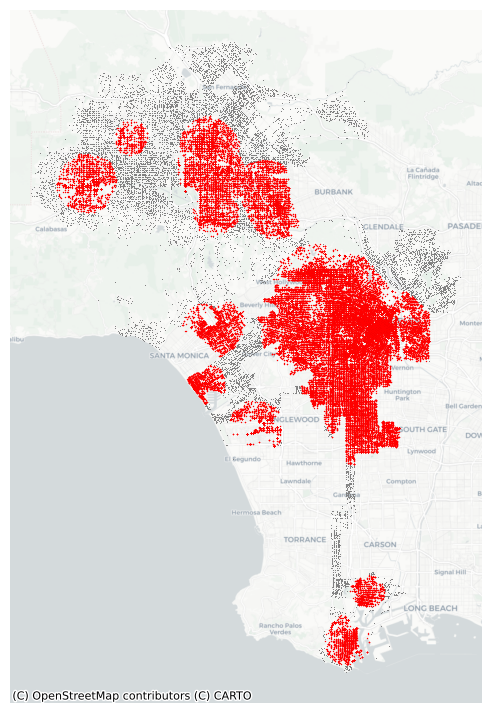

In [149]:
# Rerun DBSCAN
clusterer = DBSCAN(eps=2000, min_samples=int(minp))
clusterer.fit(gdb[["x", "y"]])
# Turn labels into a Series
lbls = pandas.Series(clusterer.labels_, index=gdb.index)
# Setup figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Subset points that are not part of any cluster (noise)
noise = gdb.loc[lbls == -1, ["x", "y"]]
# Plot noise in grey
ax.scatter(noise["x"], noise["y"], c="grey", s=0.5, linewidth=0)
# Plot all points that are not noise in red
# NOTE how this is done through some fancy indexing, where
#      we take the index of all points (db) and substract from
#      it the index of those that are noise
ax.scatter(
    gdb.loc[gdb.index.difference(noise.index), "x"],
    gdb.loc[gdb.index.difference(noise.index), "y"],
    c="red",
    s=1,
    linewidth=0,
)
# Add basemap
contextily.add_basemap(
    ax, source=contextily.providers.CartoDB.Positron
)
# Remove axes
ax.set_axis_off()
# Display the figure
plt.show()